In [61]:
import pandas_datareader as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout

# Data Loader

In [62]:
df=pd.read_csv('../dataset/train.csv')
df

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
0,20210601,A060310,3S,166690,2890,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,20210601,A054620,APS,462544,14600,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050
...,...,...,...,...,...,...,...,...
987995,20230530,A189980,흥국에프엔비,272284,3005,3035,2955,2980
987996,20230530,A000540,흥국화재,50218,3250,3255,3195,3215
987997,20230530,A003280,흥아해운,130664,1344,1395,1340,1370
987998,20230530,A037440,희림,141932,9170,9260,9170,9200


In [63]:
df = df[df['종목코드']=='A060310']
df

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
0,20210601,A060310,3S,166690,2890,2970,2885,2920
2000,20210602,A060310,3S,134833,2915,2975,2830,2900
4000,20210603,A060310,3S,144470,2900,2925,2875,2900
6000,20210604,A060310,3S,934224,2930,3120,2920,2950
8000,20210607,A060310,3S,946560,3000,3150,2955,3150
...,...,...,...,...,...,...,...,...
978000,20230523,A060310,3S,117084,2300,2315,2260,2285
980000,20230524,A060310,3S,67101,2280,2300,2255,2280
982000,20230525,A060310,3S,91789,2260,2285,2235,2245
984000,20230526,A060310,3S,13590249,2245,2915,2230,2910


In [64]:
df.shape

(494, 8)

# MinMaxScaler() 정의

In [65]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0) # 각 열에서 최솟값을 제하여 0을 기준으로 Data를 정규화
    denominator = np.max(data, 0) - np.min(data, 0) # 각 열에서 최댓값-최소값하여 정규화의 분모를 구함

    return numerator / (denominator + 1e-7) # 각 Factor를 해당 열의 최댓값-최솟값으로 나눠 0~1 사이의 값을 갖도록 함

In [66]:
dfx = df[['시가', '고가', '저가', '종가', '거래량']]
dfx = MinMaxScaler(dfx) # dfx 데이터를 정규화

dfy = dfx[['종가']]
dfx = dfx[['시가', '고가', '저가', '거래량']]

dfx

,시가,고가,저가,거래량
0,0.362534,0.347349,0.420705,0.001621
2000,0.372311,0.349177,0.396476,0.001207
4000,0.366445,0.330896,0.416300,0.001332
6000,0.378178,0.402194,0.436123,0.011601
8000,0.405553,0.413163,0.451542,0.011761
...,...,...,...,...
978000,0.131795,0.107861,0.145374,0.000976
980000,0.123973,0.102377,0.143172,0.000326
982000,0.116152,0.096892,0.134361,0.000647
984000,0.110285,0.327239,0.132159,0.176155


In [67]:
dfx.describe() #주요 통계량을 알림. 개수나 4분위 수 등

,시가,고가,저가,거래량
count,494.000000,494.000000,494.000000,494.000000
mean,0.388270,0.371748,0.428200,0.011022
std,0.223416,0.216861,0.243649,0.053506
min,0.000000,0.000000,0.000000,0.000000
25%,0.158193,0.154022,0.174559,0.001332
50%,0.390888,0.384826,0.431718,0.002464
75%,0.534611,0.504113,0.583700,0.005128
max,1.000000,1.000000,1.000000,1.000000


In [68]:
dfy.head()

,종가
0,0.358925
2000,0.351248
4000,0.351248
6000,0.370441
8000,0.447217


In [69]:
time_step = 10
step = 1

def create_dataset(X, y, time_step, step):
    Xs, ys = [], []

    for i in range(0, len(X) - time_step, step): #X길이를 벗어나지 않는 선에서 step에 따라 dataset 생성
        v = X.iloc[i : (i + time_step)].values
        labels = y.iloc[i + time_step]

        Xs.append(v) # Xs list에 v를 추가
        ys.append(labels) # 그리고 라벨추가

    return np.array(Xs), np.array(ys) # Xs, ys를 각각 numpy배열로 변환하여 반환

In [73]:
X, y = create_dataset(dfx, dfy, time_step, step)

X.shape

(484, 10, 4)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((324, 10, 4), (160, 10, 4), (324, 1), (160, 1))

# RNN

In [75]:
model = Sequential([
    SimpleRNN(20, activation='relu', input_shape=(X.shape[1:]), return_sequences=True),
    Dropout(0.5), # Dropout layer: 과적합방지
    SimpleRNN(20, activation='relu'),
    Dropout(0.3),
    Dense(1) # Dense layer: 출력을 생성
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 10, 20)            500       
                                                                 
 dropout_10 (Dropout)        (None, 10, 20)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 20)                820       
                                                                 
 dropout_11 (Dropout)        (None, 20)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1341 (5.24 KB)
Trainable params: 1341 (5.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [76]:
model.compile(loss='mse', optimizer='adam') # loss로 mse(평균제곱오차)

In [77]:
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.33, shuffle=False)

Epoch 1/500
7/7 [==============================] - 2s 51ms/step - loss: 0.5936 - val_loss: 0.0952
Epoch 2/500
7/7 [==============================] - 0s 10ms/step - loss: 0.3370 - val_loss: 0.0409
Epoch 3/500
7/7 [==============================] - 0s 9ms/step - loss: 0.1704 - val_loss: 0.0172
Epoch 4/500
7/7 [==============================] - 0s 9ms/step - loss: 0.1253 - val_loss: 0.0064
Epoch 5/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0920 - val_loss: 0.0032
Epoch 6/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0803 - val_loss: 0.0028
Epoch 7/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0857 - val_loss: 0.0029
Epoch 8/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0706 - val_loss: 0.0032
Epoch 9/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0756 - val_loss: 0.0035
Epoch 10/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0765 - val_loss: 0.0041
Epoch 11/500
7/7 [=========

7/7 [==============================] - 0s 9ms/step - loss: 0.0189 - val_loss: 0.0098
Epoch 85/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0190 - val_loss: 0.0097
Epoch 86/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0187 - val_loss: 0.0102
Epoch 87/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0182 - val_loss: 0.0117
Epoch 88/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0176 - val_loss: 0.0115
Epoch 89/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0178 - val_loss: 0.0103
Epoch 90/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0173 - val_loss: 0.0095
Epoch 91/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0197 - val_loss: 0.0099
Epoch 92/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0170 - val_loss: 0.0105
Epoch 93/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0185 - val_loss: 0.0100
Epoch 94/500
7/7 [===============

Epoch 167/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0105 - val_loss: 0.0092
Epoch 168/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0090 - val_loss: 0.0109
Epoch 169/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0121 - val_loss: 0.0101
Epoch 170/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0088 - val_loss: 0.0099
Epoch 171/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0087 - val_loss: 0.0117
Epoch 172/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0108 - val_loss: 0.0113
Epoch 173/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0103 - val_loss: 0.0106
Epoch 174/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0124 - val_loss: 0.0109
Epoch 175/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0097 - val_loss: 0.0107
Epoch 176/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0093 - val_loss: 0.0099
Epoch 177/

7/7 [==============================] - 0s 9ms/step - loss: 0.0075 - val_loss: 0.0127
Epoch 250/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0066 - val_loss: 0.0119
Epoch 251/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0077 - val_loss: 0.0126
Epoch 252/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0134
Epoch 253/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0067 - val_loss: 0.0118
Epoch 254/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0113
Epoch 255/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0082 - val_loss: 0.0122
Epoch 256/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0083 - val_loss: 0.0130
Epoch 257/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0081 - val_loss: 0.0123
Epoch 258/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0064 - val_loss: 0.0121
Epoch 259/500
7/7 [

7/7 [==============================] - 0s 9ms/step - loss: 0.0065 - val_loss: 0.0151
Epoch 332/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0067 - val_loss: 0.0148
Epoch 333/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0059 - val_loss: 0.0141
Epoch 334/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0067 - val_loss: 0.0145
Epoch 335/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0058 - val_loss: 0.0147
Epoch 336/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0066 - val_loss: 0.0146
Epoch 337/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0056 - val_loss: 0.0143
Epoch 338/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0067 - val_loss: 0.0148
Epoch 339/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0076 - val_loss: 0.0142
Epoch 340/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0077 - val_loss: 0.0146
Epoch 341/500
7/7 [=====

7/7 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 0.0138
Epoch 414/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0078 - val_loss: 0.0144
Epoch 415/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0053 - val_loss: 0.0147
Epoch 416/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0060 - val_loss: 0.0145
Epoch 417/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0068 - val_loss: 0.0147
Epoch 418/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0056 - val_loss: 0.0144
Epoch 419/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0064 - val_loss: 0.0145
Epoch 420/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0057 - val_loss: 0.0150
Epoch 421/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0055 - val_loss: 0.0138
Epoch 422/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0055 - val_loss: 0.0143
Epoch 423/500
7/7 [=====

Epoch 496/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0061 - val_loss: 0.0146
Epoch 497/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0061 - val_loss: 0.0154
Epoch 498/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0062 - val_loss: 0.0143
Epoch 499/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0060 - val_loss: 0.0140
Epoch 500/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0146


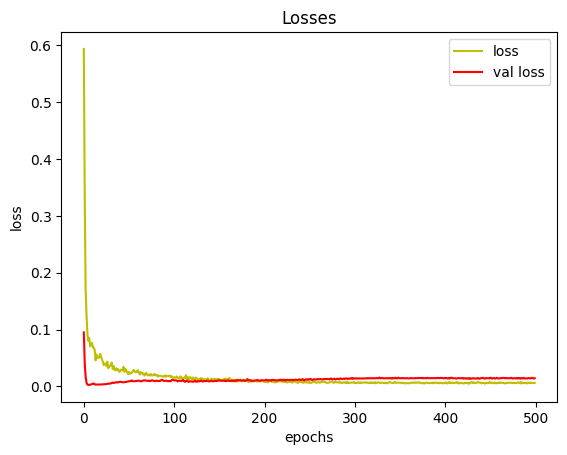

In [78]:
loss = history.history['loss']
val_loss = history.history['val_loss']

x = np.arange(0, len(history.history['loss']))

plt.plot(x, loss, 'y', label='loss')
plt.plot(x, val_loss, 'r', label='val loss')
plt.title('Losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [79]:
y_pred = model.predict(X_test)

5/5 [==============================] - 0s 2ms/step


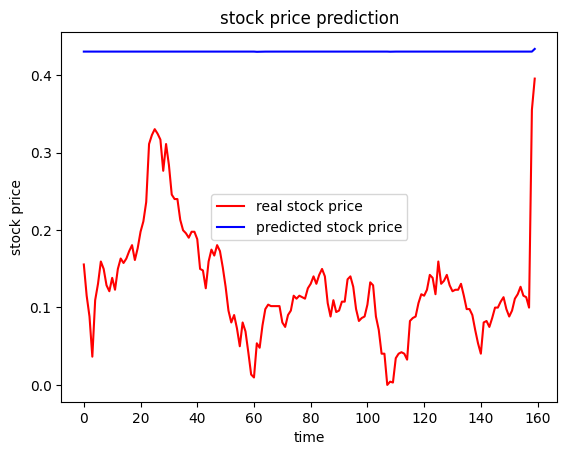

In [80]:
y_pred.shape

plt.plot(y_test, color='red', label='real stock price')
plt.plot(y_pred, color='blue', label='predicted stock price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

# LSTM

In [81]:
# 두 데이터를 리스트 형태로 저장
X1 = dfx.values.tolist()
y1 = dfy.values.tolist()

In [82]:
window_size = 20

data_X = []
data_y = []
for i in range(len(y1) - window_size):
    _X = X1[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = y1[i + window_size]     # 다음 날 종가
    data_X.append(_X)
    data_y.append(_y)
print(_X, "->", _y)

[[0.07704341024336944, 0.05484460694497826, 0.07488986783811058, 0.0012808444922087566], [0.06335549471789771, 0.04570383912081522, 0.07048458149469232, 0.001199113634964142], [0.05357841219970363, 0.06581352833397391, 0.07488986783811058, 0.0013334117616710503], [0.09073132576884117, 0.07312614259330436, 0.10792951541374761, 0.0003301869423682774], [0.09268674227247999, 0.06581352833397391, 0.0947136563834928, 0.00034377407978803916], [0.08682049276156353, 0.07312614259330436, 0.11233480175716587, 0.00029817590664822625], [0.09464215877611881, 0.08226691041746739, 0.11894273127229328, 0.0013799850882141953], [0.11028549080522936, 0.08592321754713261, 0.1255506607874207, 0.000483299028736808], [0.114196323812507, 0.1042047531954587, 0.1343612334742572, 0.0012070058765084437], [0.11810715681978463, 0.10054844606579348, 0.1387665198176755, 0.00042293053204785696], [0.12006257332342345, 0.09506398537129565, 0.12995594713083897, 0.0003577772826598893], [0.10833007430159054, 0.0840950639823

In [83]:
print('전체 데이터의 크기 :', len(data_X), len(data_y))

전체 데이터의 크기 : 474 474


In [84]:
train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (331, 20, 4) (331, 1)
테스트 데이터의 크기 : (143, 20, 4) (143, 1)


In [85]:
model = Sequential()
model.add(LSTM(units=20, activation='relu', return_sequences=True, input_shape=(20, 4)))
model.add(Dropout(0.1))
model.add(LSTM(units=20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 20, 20)            2000      
                                                                 
 dropout_12 (Dropout)        (None, 20, 20)            0         
                                                                 
 lstm_7 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_13 (Dropout)        (None, 20)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5301 (20.71 KB)
Trainable params: 5301 (20.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [86]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_X, train_y, epochs=70, batch_size=30)
pred_y = model.predict(test_X)

Epoch 1/70
12/12 [==============================] - 2s 12ms/step - loss: 0.2632
Epoch 2/70
12/12 [==============================] - 0s 12ms/step - loss: 0.1380
Epoch 3/70
12/12 [==============================] - 0s 11ms/step - loss: 0.0305
Epoch 4/70
12/12 [==============================] - 0s 11ms/step - loss: 0.0196
Epoch 5/70
12/12 [==============================] - 0s 12ms/step - loss: 0.0162
Epoch 6/70
12/12 [==============================] - 0s 11ms/step - loss: 0.0170
Epoch 7/70
12/12 [==============================] - 0s 11ms/step - loss: 0.0136
Epoch 8/70
12/12 [==============================] - 0s 11ms/step - loss: 0.0145
Epoch 9/70
12/12 [==============================] - 0s 11ms/step - loss: 0.0112
Epoch 10/70
12/12 [==============================] - 0s 11ms/step - loss: 0.0155
Epoch 11/70
12/12 [==============================] - 0s 12ms/step - loss: 0.0147
Epoch 12/70
12/12 [==============================] - 0s 12ms/step - loss: 0.0146
Epoch 13/70
12/12 [==================

In [87]:
model.evaluate(test_X, test_y)

5/5 [==============================] - 0s 5ms/step - loss: 0.0034


0.0034204386174678802

5/5 [==============================] - 0s 4ms/step


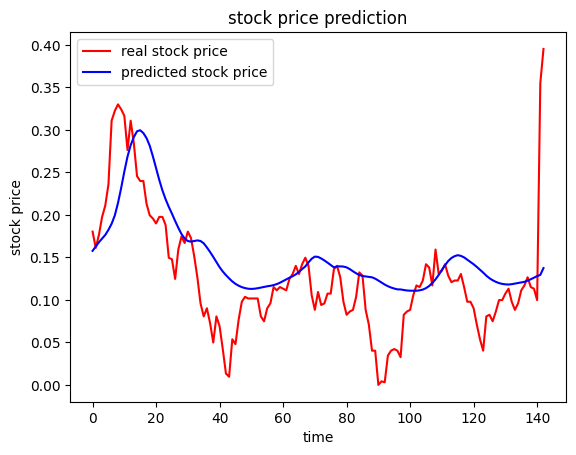

In [88]:
pred_y = model.predict(test_X)

plt.figure()
plt.plot(test_y, color='red', label='real stock price')
plt.plot(pred_y, color='blue', label='predicted stock price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()